# Aplikasi Sampling Penutup Lahan
## Bagian 1. Proportional Sample Generator

2021-08-06

Kualitas sampel yang baik adalah salah satu kunci keberhasilan membangun model supervised classification. Untuk mendukung proses klasifikasi penutup lahan dengan supervised classification algorithm, berikut ini dikembangkan rangkaian proses pengumpulan titik sampel penutup lahan pada platform Jupyter.

Bagian ini merupakan bagian pertama dari dua bagian aplikasi sampling penutup lahan. Bagian ini meliputi proses pembuatan titik sampel secara proporsional berdasarkan luasan region cluster. Region cluster dibangun dengan menggunakan pendekatan K-Means Clustering, dengan input enam saluran citra Landsat dan digital elevation model SRTM.

## Preparation

In [1]:
# Import required packages
import geemap
import ee
import pandas as pd

In [2]:
# Authorize EE Access
ee.Authenticate()

Enter verification code: 4/1AX4XfWiqPQgfqZ2N0NjDMKutXuM0DldVwftmkT1B8QLbHrlz518_k6_dZTQ

Successfully saved authorization token.


In [3]:
# Initialize EE account
ee.Initialize()

## Dataset

In [4]:
# Define study area
Borneo = ee.Geometry.Rectangle(108.028633, 7.370019, 119.507898, -5.101769)
studyArea = Borneo

In [5]:
# Layers
img_landsat = ee.Image('users/kfaisal/LCMS_Borneo_2016/L8_Borneo_2016_int')
img_srtm = ee.Image('USGS/SRTMGL1_003')
img_stack = ee.Image([img_landsat, img_srtm]).clip(studyArea)

# Add layers to map
Map = geemap.Map()
Map.addLayer(img_stack, {'bands': ['B5','B6','B7'], 'min': 40, 'max': 4000}, 'Landsat image')
Map.centerObject(img_stack, 7)

# Display map
Map

Map(center=[1.135209189203904, 113.76826550000001], controls=(WidgetControl(options=['position', 'transparent_…

## K-Means Clustering

In [6]:
# Generate 10000 random samples and extract image values
## Sampling
randSamp = ee.FeatureCollection.randomPoints(
    region = studyArea,
    points = 10000
)
## Image sampling
imgSamp = img_stack.sampleRegions(
    collection = randSamp,
    scale = 30
)
## Convert sample features to pandas dataframe
imgSamp_pd = geemap.ee_to_pandas(imgSamp)
### showing 5 top rows of samples dataframe
imgSamp_pd.head(5)

,B2,B3,B4,B5,B6,B7,elevation
0,129,320,180,2951,1008,362,30
1,165,371,203,2957,1173,430,75
2,239,540,304,4199,1560,560,49
3,586,770,827,2054,2057,1281,4
4,177,362,248,3185,1176,469,969


### Optional: Find optimal k number using Elbow Method

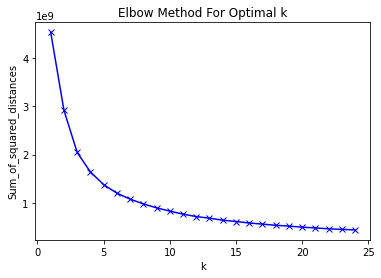

In [7]:
# Find optimum number of K-Means Cluster using Elbow Method
# (https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Sum_of_squared_distances = []
K = range(1,25)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(imgSamp_pd)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [8]:
# Define number of clusters
numClust = 15

In [9]:
# Run k-means clustering
kmeans = ee.Clusterer.wekaKMeans(numClust).train(imgSamp)
cluster_k = img_stack.cluster(kmeans).rename('cluster')
Map.addLayer(cluster_k.randomVisualizer(), {}, 'Cluster image')
Map

Map(bottom=16581.0, center=[1.135209189203904, 113.76826550000001], controls=(WidgetControl(options=['position…

## Generate proportionally stratified random samples

In [10]:
# Number of output point samples
numSamples = 1000

In [11]:
# Proportional random sampling
areaImage = ee.Image.pixelArea().addBands(cluster_k)

# Calculate per-cluster area
areas = areaImage.reduceRegion(
    reducer = ee.Reducer.sum().group(
        groupField = 1,
        groupName = 'cluster'),
    geometry = studyArea,
    scale = 100,
    maxPixels = 1e13)
classAreas = ee.List(areas.get('groups'))

# List of cluster
def classnum(item):
    areaDict = ee.Dictionary(item)
    classNumber = ee.Number(areaDict.get('cluster'))
    return classNumber
classNumLists = classAreas.map(classnum)
numValues = ee.Array(classNumLists).round().int().toList()
# print('List of clusters:', numValues.getInfo())

# List of per-class area
def classarea(item):
    areaDict = ee.Dictionary(item)
    area = ee.Number(areaDict.get('sum')).divide(1e4).round()
    return area
classAreaLists = classAreas.map(classarea)
totalArea = ee.Number(classAreaLists.reduce(ee.Reducer.sum()))
# print('Total area of study area in ha: ', totalArea.getInfo())

# Generate number of points proportionally
numPoints = ee.Array(classAreaLists).divide(totalArea).multiply(numSamples).round().int().toList()
print('Number of proportionally points each cluster:', numPoints.getInfo())

# Generate proportional sample points
stratified = cluster_k.stratifiedSample(
  numPoints = numSamples,
  classBand = 'cluster',
  classValues = numValues,
  classPoints = numPoints,
  scale = 100,
  region = studyArea,
  geometries = True)

Number of proportionally points each cluster: [94, 45, 21, 50, 72, 157, 189, 8, 141, 31, 30, 56, 43, 48, 16]


## Export to Drive

In [12]:
folderName = 'LCMS_samples'
exportName = 'Borneo_2016'

In [16]:
# Export samples to Drive
from datetime import date
today = date.today()
todaydate = today.strftime("%b-%d-%Y")

exportTask = ee.batch.Export.table.toDrive(
    collection = stratified,
    description = todaydate + '_' + exportName + '_stratifiedsamples_' + str(numClust) + '_' + str(numSamples),
    folder = folderName,
    fileFormat = 'CSV')
exportTask.start()

In [15]:
exportTask.status()

{'state': 'READY',
 'description': 'Aug-06-2021_Borneo_2016_stratifiedsamples_15_1000',
 'creation_timestamp_ms': 1628239803365,
 'update_timestamp_ms': 1628239803365,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_FEATURES',
 'id': 'P5YKS2YWAZYGLAJWXQPOUYIG',
 'name': 'projects/earthengine-legacy/operations/P5YKS2YWAZYGLAJWXQPOUYIG'}